# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [197]:
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Run the following to downlaod the dataset
>>> sh get_datasets.sh

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data generated by the sh file, change the folder for your folder
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
        del X_train, y_train
        del X_test, y_test
        print('Clear previously loaded data.')
    except:
        pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    print(mean_image)
    print(len(mean_image))
    
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

[130.64189796 135.98173469 132.47391837 ... 126.64218367 125.86195918
 114.39957143]
3072
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


### Non-vectorized softmax

In [116]:
import numpy as np
from random import shuffle

def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    scores = X@W
    # Softmax Loss
    for i in range(X.shape[0]): # 0 to mini batch size
        f = scores[i] - np.max(scores[i]) # shift the values so that the highest number is 0 in order to avoid numerical instability
        softmax = np.exp(f)/np.sum(np.exp(f)) # e^xi/Σij e^xj
        loss += -np.log(softmax[y[i]]) #accumulate losses to average later
        # Weight Gradients
        for j in range(W.shape[1]): # 0 to num of classes
            dW[:,j] += X[i] * softmax[j] # column gradient is: for every image, its probabilities vector(10x1) * single image(1,3073) - the right image itself in the right column
        dW[:,y[i]] -= X[i] # decrease the image vector associated with the right label in dW column

    # Average for the mini-batch
    loss /= X.shape[0]
    dW /= X.shape[0]

    # Regularization
    loss += reg * np.sum(W * W)
    dW += reg * 2 * W 

    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dW

In [7]:
def accuracy(W,X,Y):
    correct=0
    for i in range(X.shape[0]):
        forward = X[i]@W
        if np.argmax(forward) == Y[i]:
            correct+=1
    return correct/X.shape[0]

### Backpropagation using non-vectorized Softmax

In [188]:
import time
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
step_size = 1e-6
num_epoches = 100
train = False

if train:
    for i in range(num_epoches):
        loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
        W +=  grad*(-step_size) 
        acc = accuracy(W,X_test,y_test)
        print(f"epoch {i}: loss for the mini-batch: {loss}         acc: {acc}")
else:
    loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)
    acc = accuracy(W,X_test,y_test)
    print(f"loss: {loss}")
    print(f"acc: {acc}")

# As a rough sanity check, our loss should be something closeto -log(0.1).
print(f"sanity check : {-np.log(0.1):4f}")

loss: 2.3375307335860303
acc: 0.108
sanity check : 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{green}{\textit Your Answer:}$ *Since our W matrix initialization was done with values close to 0 (i.e *0.0001), we expect that each class has an equal chance to be choosen, then we expect loss to be -log(1/num_of_classes), which in this case is -log(0.1)* 



In [ ]:
### 

In [128]:
from random import randrange
def grad_check_sparse(f, x, analytic_grad, num_values=10, h=1e-5):
    """
    https://cs231n.github.io/optimization-1/ > centered difference formula: [f(x+h)−f(x−h)]/2h
    Takes num_values random values from W matrix and check using limit gradient concept.
    """

    for i in range(num_values):
        ix = tuple([randrange(m) for m in x.shape]) # tuple with W matrix index for some value
        val = x[ix]
        x[ix] = val + h # increment by h
        fx_plus_h = f(x) # evaluate f(x + h)
        x[ix] = val - h # decrement by h
        fx_minus_h = f(x) # evaluate f(x - h)
        x[ix] = val # reset
        
        grad_numerical = (fx_plus_h - fx_minus_h) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print(f"Numerical gradient: {grad_numerical:.4f}  Analytic gradient: {grad_analytic:.4f} - Relative error: {rel_error}")

### Gradient check for non-vectorized backpropagation

In [130]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
print("Gradient check:\n")
grad_check_sparse(f, W, grad, 10)
print("\nGradient check with regularization:\n")
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.000005)[0]
grad_check_sparse(f, W, grad, 10)

Gradient check:

Numerical gradient: 1.3707  Analytic gradient: 1.3707 - Relative error: 9.731270501233065e-09
Numerical gradient: 0.3912  Analytic gradient: 0.3912 - Relative error: 4.9258284538863496e-08
Numerical gradient: 1.6209  Analytic gradient: 1.6209 - Relative error: 2.266437848243549e-08
Numerical gradient: 0.5032  Analytic gradient: 0.5032 - Relative error: 1.167063609770184e-07
Numerical gradient: 1.1272  Analytic gradient: 1.1272 - Relative error: 7.916988842609602e-10
Numerical gradient: 1.7326  Analytic gradient: 1.7326 - Relative error: 1.9567711497969526e-08
Numerical gradient: 0.4380  Analytic gradient: 0.4380 - Relative error: 6.52327002955515e-08
Numerical gradient: -0.5506  Analytic gradient: -0.5506 - Relative error: 8.23999935061954e-08
Numerical gradient: -1.7804  Analytic gradient: -1.7804 - Relative error: 6.024141804884286e-09
Numerical gradient: -0.1154  Analytic gradient: -0.1154 - Relative error: 1.8545182329837218e-07

Gradient check with regularization:

### Vectorized softmax

In [163]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.
    Inputs and outputs are the same as softmax_loss_naive.
    """
    loss = 0.0
    dW = np.zeros_like(W)
    
    # loss
    num_train = X.shape[0]
    scores = X@W
    scores = scores - np.max(scores, axis=1, keepdims=True) # numerical instability
    sum_exp_scores = np.exp(scores).sum(axis=1, keepdims=True)# Σij e^xj
    softmax_matrix = np.exp(scores)/sum_exp_scores
    loss = np.sum(-np.log(softmax_matrix[np.arange(num_train), y])) # softmax is unnormalized probabilities, log is probabilities vector,  sum all 500(mini-batch size) losses for the given y label, average them later
    
    # gradients
    softmax_matrix[np.arange(num_train),y] -= 1 # update softmax unnormalized matrix by decrementing the right label for each image vector
    dW = X.T@softmax_matrix # vectorized version https://github.com/GabrielDornelles/math/blob/main/Matrix_partial-derivative_backpropagation.ipynb
    
    # Average
    loss /= num_train
    dW /= num_train

    # Regularization
    loss += reg * np.sum(W * W)
    dW += reg * 2 * W 
    return loss, dW

### Gradient Check for vectorized backpropagation

In [164]:
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
print("Gradient check:\n")
grad_check_sparse(f, W, grad, 10)
print("\nGradient check with regularization:\n")
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 0.000005)[0]
grad_check_sparse(f, W, grad, 10)

Gradient check:

Numerical gradient: -5.5644  Analytic gradient: -5.5644 - Relative error: 1.19004964904436e-08
Numerical gradient: 2.3441  Analytic gradient: 2.3441 - Relative error: 1.5012406607492248e-08
Numerical gradient: 3.0910  Analytic gradient: 3.0910 - Relative error: 1.4896951556728153e-08
Numerical gradient: -1.1297  Analytic gradient: -1.1297 - Relative error: 2.1118024108969844e-08
Numerical gradient: -2.7830  Analytic gradient: -2.7830 - Relative error: 1.9433196090655692e-08
Numerical gradient: -0.7584  Analytic gradient: -0.7584 - Relative error: 2.2560441580328954e-08
Numerical gradient: 0.8312  Analytic gradient: 0.8312 - Relative error: 8.349336955393482e-08
Numerical gradient: -0.1050  Analytic gradient: -0.1050 - Relative error: 4.199878397328471e-07
Numerical gradient: -0.0638  Analytic gradient: -0.0638 - Relative error: 7.923651765957849e-07
Numerical gradient: -3.4196  Analytic gradient: -3.4196 - Relative error: 1.585288702336765e-08

Gradient check with regu

### Vectorized vs Non-vectorized backpropagation runtime

In [173]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print(f"naive loss: {loss_vectorized} computed in {(toc-tic)*1000:.3f} ms")

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print(f"vectorized loss: {loss_vectorized} computed in {(toc-tic)*1000:.3f} ms")

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.3478611789411996 computed in 61.099 ms
vectorized loss: 2.3478611789411996 computed in 3.255 ms
Loss difference: 0.000000
Gradient difference: 0.000000


In [200]:
#if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
W = np.random.randn(3073, 10) * 0.0001
step_size = 2.50000e-06
num_epoches = 1000
train = True
best_acc = 0
if train:
    for i in range(num_epoches):
        loss, grad = softmax_loss_vectorized(W, X_train, y_train, 1.000000e+03)
        W +=  grad*(-step_size) 
        acc = accuracy(W,X_test,y_test)
        if acc> best_acc:
            best_acc = acc
            best_W = W
        if i%50==0:print(f"epoch {i}: loss for the mini-batch: {loss}         acc: {acc}")
    print(f"best accuracy: {best_acc}")

epoch 0: loss for the mini-batch: 2.6465739150588963         acc: 0.23
epoch 50: loss for the mini-batch: 2.039816662919355         acc: 0.366
epoch 100: loss for the mini-batch: 1.9433925270283174         acc: 0.387
epoch 150: loss for the mini-batch: 1.8923481389208858         acc: 0.39
epoch 200: loss for the mini-batch: 1.8631771263400818         acc: 0.388
epoch 250: loss for the mini-batch: 1.8461081512786146         acc: 0.39
epoch 300: loss for the mini-batch: 1.8360154216304494         acc: 0.39
epoch 350: loss for the mini-batch: 1.8300129840464843         acc: 0.39
epoch 400: loss for the mini-batch: 1.8264300526895165         acc: 0.391
epoch 450: loss for the mini-batch: 1.8242859944822558         acc: 0.392
epoch 500: loss for the mini-batch: 1.8230006642256837         acc: 0.395
epoch 550: loss for the mini-batch: 1.8222290985071274         acc: 0.394
epoch 600: loss for the mini-batch: 1.821765464762076         acc: 0.394
epoch 650: loss for the mini-batch: 1.8214866437

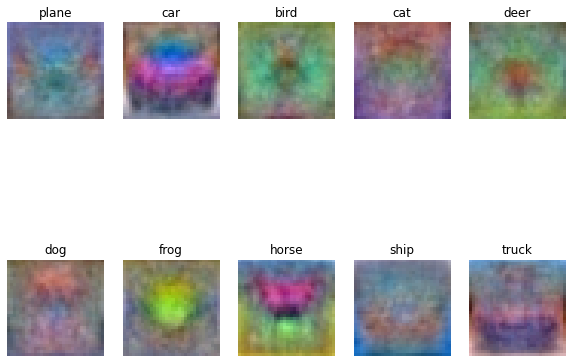

In [201]:
# Visualize the learned weights for each class

w = best_W[:-1,:] #strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Thanks for Andrej Karpathy for the free absolutely god tier classes.